## Data and Libraries

In [1]:
import matplotlib.colors as mc # For the legend
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Another utility for the legend
from matplotlib.cm import ScalarMappable

This article is based on [this blogpost](https://www.r-graph-gallery.com/283-the-hourly-heatmap.html) in the [R Graph Gallery](https://www.r-graph-gallery.com/), contributed by [John MacKintosh](http://johnmackintosh.com/).

This guide uses one of the datasets from the [Interpol.T](https://CRAN.R-project.org/package=Interpol.T) [R](https://www.r-graph-gallery.com/) package. The data loaded here is the one named `h_d_t` in the package and contains hourly temperature for Trentino, Italy, from 2004 to 2005.  It contains the following columns:

* `stationid` The id of the station
* `date` Date in yyyy/mm/dd format
* `hour` The hour that is commencing (integer 0,...23), 
* `temp` The temperature reported in that hour
* `flag` A quality flag that is actually unused. 

In addition, the data has been filtered to keep only observations for the station `"T0001"`.

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/trentino_temperature.csv")
data["date"] = pd.to_datetime(data["date"])
data

,stationid,date,hour,temp,flag
0,T0001,2004-01-01,0,-1.7,1
1,T0001,2004-01-01,1,-1.8,1
2,T0001,2004-01-01,2,-1.8,1
3,T0001,2004-01-01,3,-2.2,1
4,T0001,2004-01-01,4,-3.2,1
...,...,...,...,...,...
17539,T0001,2005-12-31,19,-3.4,1
17540,T0001,2005-12-31,20,-3.3,1
17541,T0001,2005-12-31,21,-3.3,1
17542,T0001,2005-12-31,22,-3.3,1


We use `pd.to_datetime()` to make sure `data["date"]` is of a datetime type.

## Basic heatmap

A [heatmap](https://www.data-to-viz.com/graph/heatmap.html) is a graphical representation of numerical data in a matrix layout where individual values are cells in the matrix and are represented as colors. 

In this case, the rows represent the 24 **hours** of the day, and the columns represent the **days** in a month. The **temperature** is mapped to colors. This way, it's possible to see which days were cooler/hotter by comparing columns, and see the evolution of temperature of a given day by seeing the progression of colors within a certain column.

Let's create a heatmap for the January of 2004.

In [3]:
# Subset data
subset = data[(data["date"].dt.year == 2004) & (data["date"].dt.month == 1)]

# Extract hour, day, and temperature
hour = subset["hour"]
day = subset["date"].dt.day
temp = subset["temp"]

# Re-arrange temperature values
temp = temp.values.reshape(24, len(day.unique()), order="F")

# Compute x and y grids, passed to `ax.pcolormesh()`.

# The first + 1 increases the length
# The outer + 1 ensures days start at 1, and not at 0.
xgrid = np.arange(day.max() + 1) + 1

# Hours start at 0, length 2
ygrid = np.arange(25)

Note both `xgrid` and `ygrid` have one extra value, as required by `ax.pcolormesh()`. If this is not added, the plot is just not going to work.

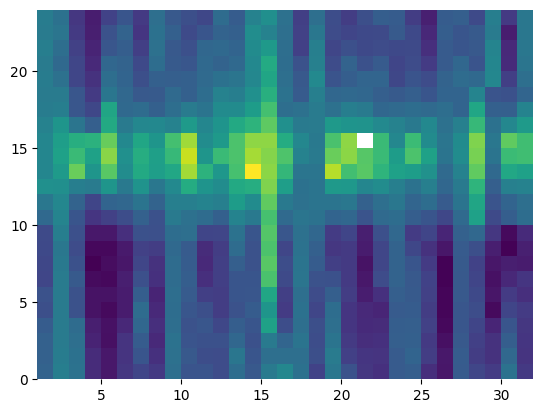

In [4]:
fig, ax = plt.subplots()
ax.pcolormesh(xgrid, ygrid, temp)
ax.set_frame_on(False) # remove all spines

The white cell represents a **missing value**. There are 5 missings in this data.

## A layout of heatmaps

The next step is to extend the code above to multiple heatmaps, one for each month in the two years from 2004 and 2005. The following chunk shows how to compute the minimum and maximum temperature. It is **very important** to use these two values as minimum and maximum for all the heatmaps so the same colormap is applied to all the panels and they can be compared. Otherwise, Matplotlib creates a different colormap for each panel and the result would be misleading.

In [5]:
MIN_TEMP = data["temp"].min()
MAX_TEMP = data["temp"].max()

This function summarizes the process above and also customizes the result a little. This tweaks are described with comments within the code.

In [6]:
def single_plot(data, month, year, ax):
    data = data[(data["date"].dt.year == year) & (data["date"].dt.month == month)]

    hour = data["hour"]
    day = data["date"].dt.day
    temp = data["temp"]
    temp = temp.values.reshape(24, len(day.unique()), order="F")
    
    xgrid = np.arange(day.max() + 1) + 1
    ygrid = np.arange(25)
    
    ax.pcolormesh(xgrid, ygrid, temp, cmap="magma", vmin=MIN_TEMP, vmax=MAX_TEMP)
    # Invert the vertical axis
    ax.set_ylim(24, 0)
    # Set tick positions for both axes
    ax.yaxis.set_ticks([i for i in range(24)])
    ax.xaxis.set_ticks([10, 20, 30])
    # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    
    # Remove all spines
    ax.set_frame_on(False)

And finally, let's create a figure with 2 rows and 12 columns and loop through each month:

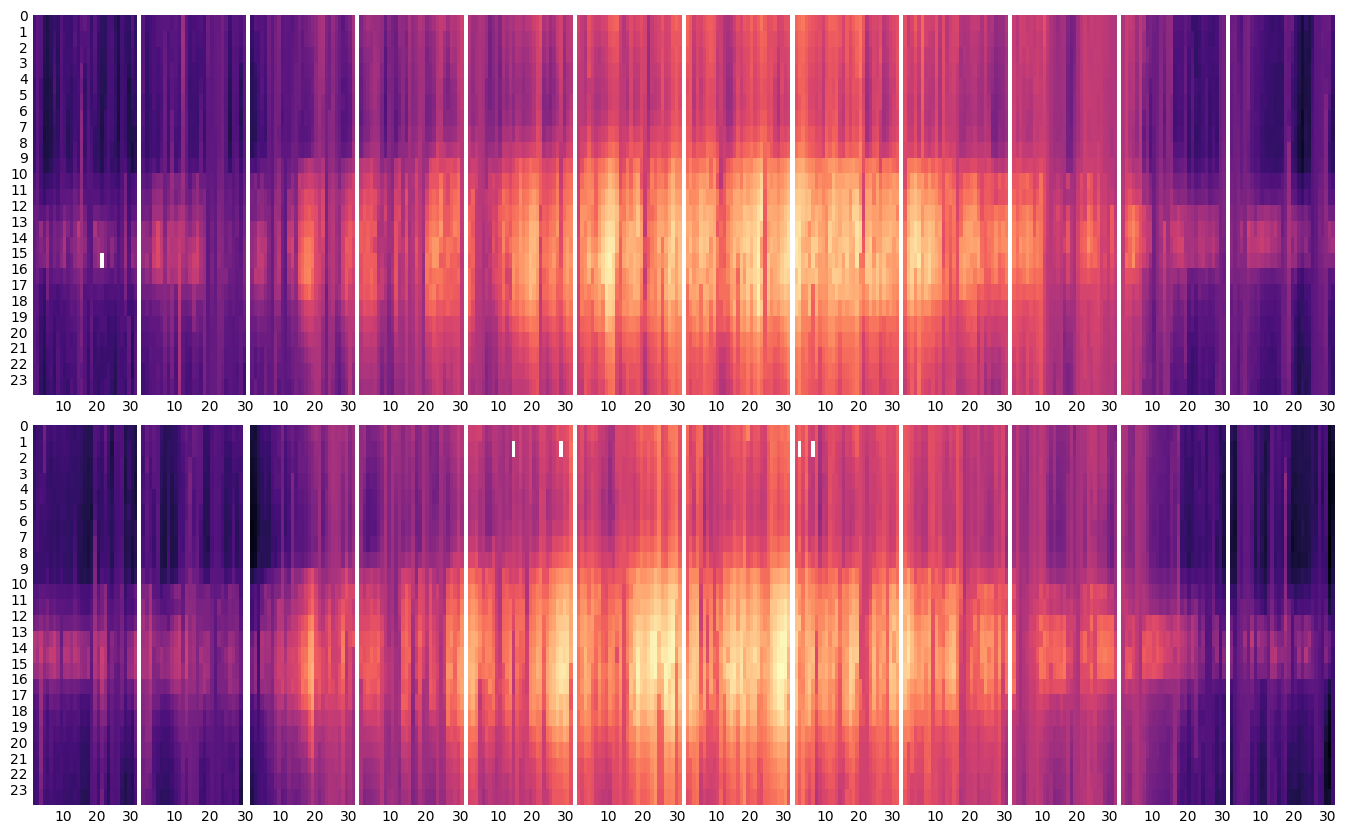

In [7]:
fig, axes = plt.subplots(2, 12, figsize=(14, 10), sharey=True)

for i, year in enumerate([2004, 2005]):
    for j, month in enumerate(range(1, 13)):
        single_plot(data, month, year, axes[i, j])

# Adjust margin and space between subplots
# Extra space is on the left to add a label
fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0.04)

It's good to have a legend with a colorbar that describes the values represented by the colors. Let's add one!

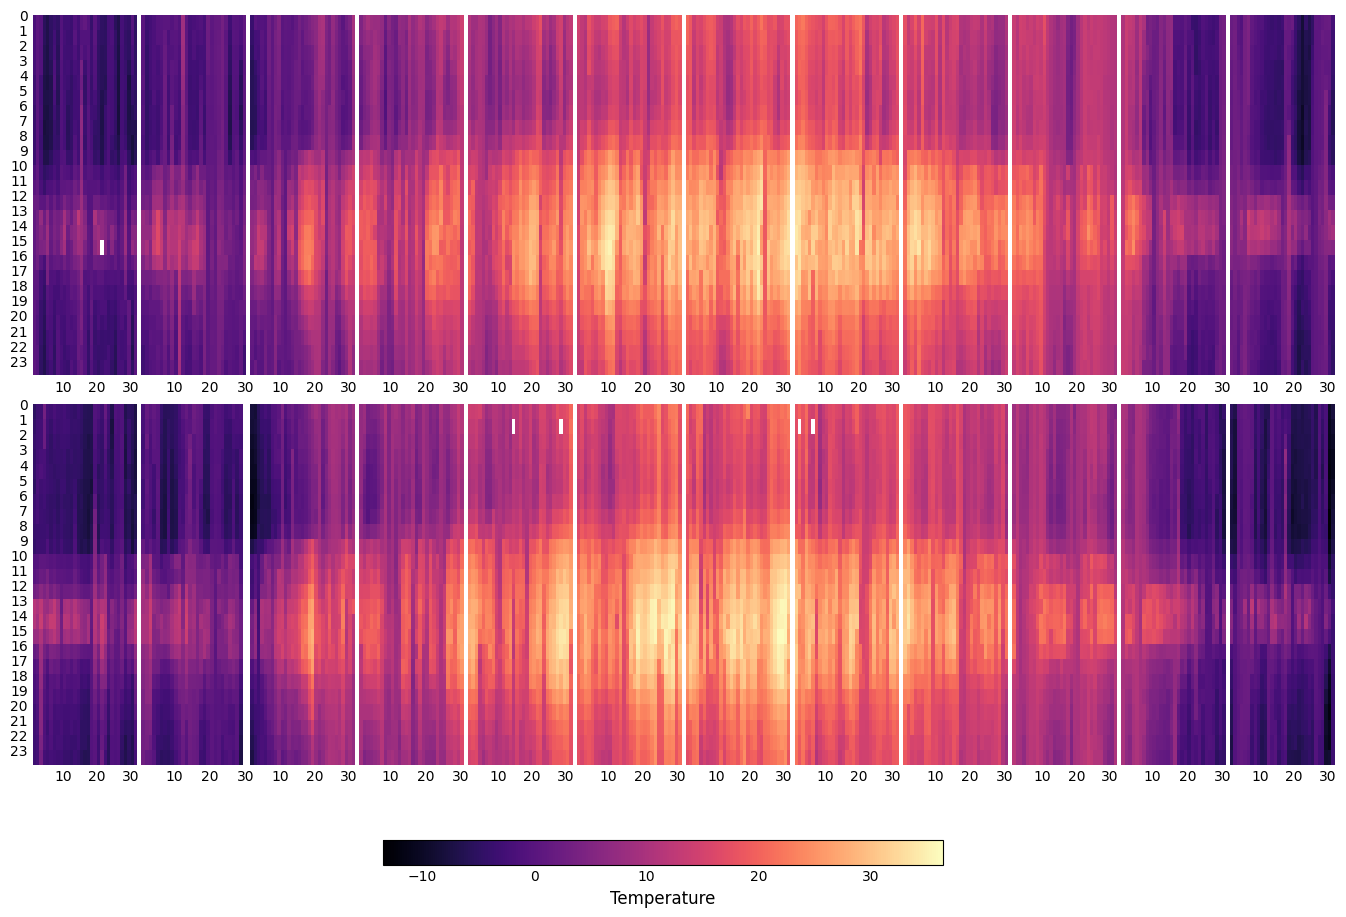

In [8]:
# First, let's make some room for the legend in the bottom.
fig.subplots_adjust(bottom=0.15)

# Create a new axis to contain the color bar
# Values are:
# (x coordinate of left border, 
#  y coordinate for bottom border,
#  width,
#  height)
cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.025])

# Create a normalizer that goes from minimum to maximum temperature
norm = mc.Normalize(MIN_TEMP, MAX_TEMP)

# Create the colorbar and set it to horizontal
cb = fig.colorbar(
    ScalarMappable(norm=norm, cmap="magma"), 
    cax=cbar_ax, # Pass the new axis
    orientation = "horizontal"
)

# Remove tick marks
cb.ax.xaxis.set_tick_params(size=0)

# Set legend label
cb.set_label("Temperature", size=12)
fig

Let's finish by adding some labels and an appropriate title

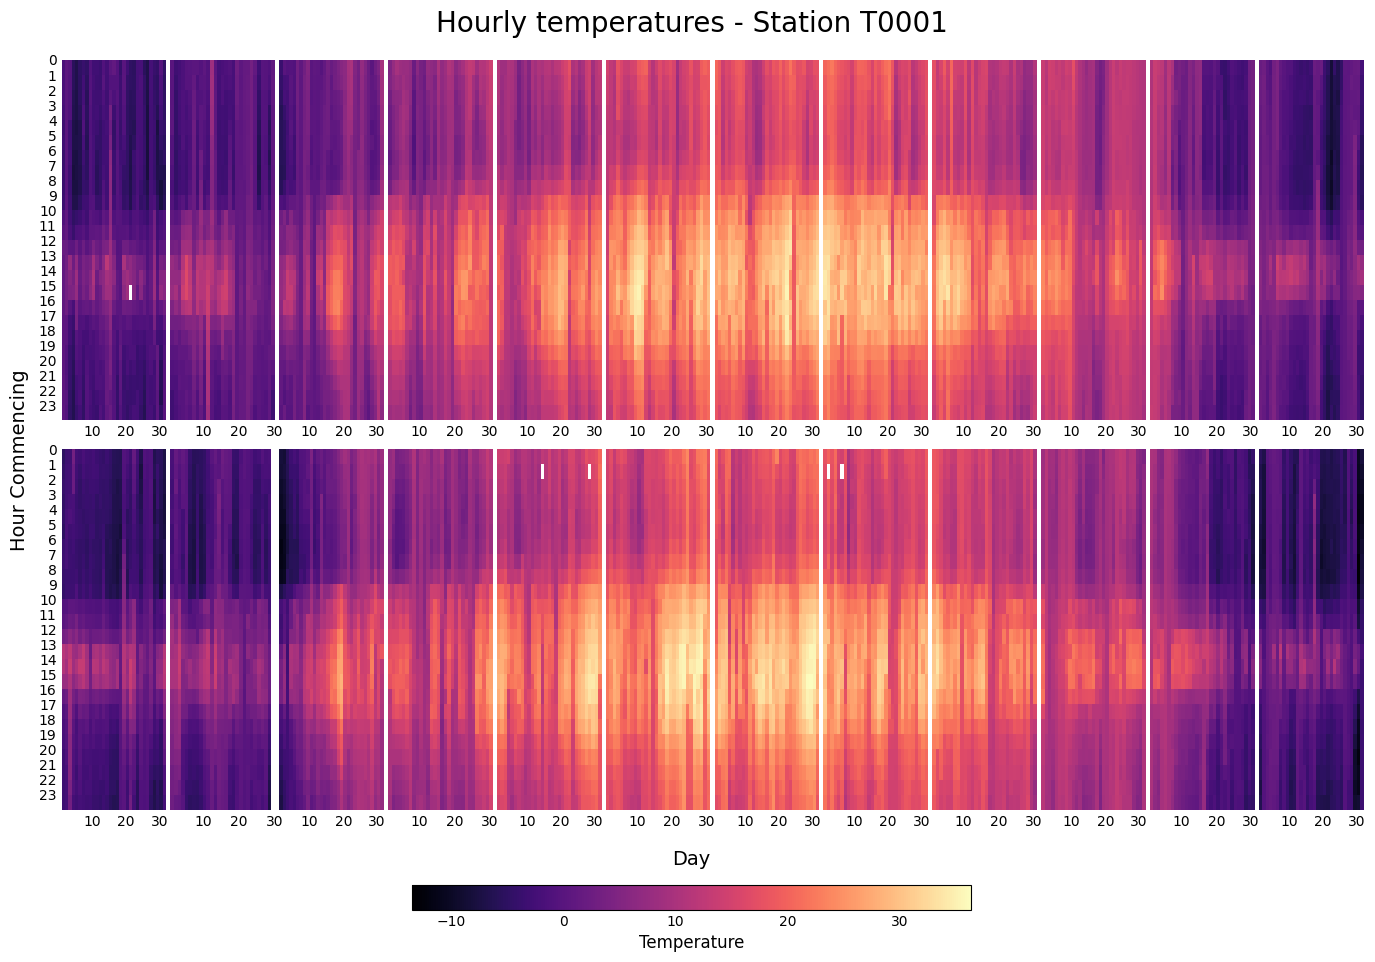

In [9]:
# Set common labels for x and y axes
fig.text(0.5, 0.1, "Day", ha="center", va="center", fontsize=14)
fig.text(0.02, 0.5, 'Hour Commencing', ha="center", va="center", rotation="vertical", fontsize=14)

fig.suptitle("Hourly temperatures - Station T0001", fontsize=20, y=0.95)
fig

In [10]:
# If you want to save this plot, run:
# fig.set_facecolor("white")
# fig.savefig("plot.png", dpi=300)